# Identifying Fraudulent Credit Card Transactions Using a One-Class Support Vector Machine (SVM) Model

**Resources** 
- [Geeks for Geeks - Understanding One-Class Support Vector Machines](https://www.geeksforgeeks.org/understanding-one-class-support-vector-machines/)
- [Scikit-learn - OneClassSVM Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html)

In [1]:
## Logger configuration
from loguru import logger

logger.remove()

logger.add("logs/ocsvm.log",
           level = "DEBUG",
           format = "{time:HH:mm:ss} | {level} | {message}")

1

## Load and Pre-Process Dataset

In [2]:
import pandas as pd 

df = pd.read_csv("../creditcard.csv")

target_feature = "Class"
input_features = list(df.columns)
input_features.remove(target_feature)

logger.info(f"Dataset loaded")
logger.debug(f"Dataset Shape: {df.shape}")
logger.debug(f"Percentage Fraudulent Transactions: {df["Class"].sum() / df.shape[0]}")
logger.debug(f"Target Variable: {target_feature}")
logger.debug(f"Input Variables: {input_features}")

#### Downsampling

To accomodate for this dataset being quite large, we downsample the dataset for the purposes of testing the code.

- The sample is 30% of the original data set 
- The sample contains the sample class distribution as the original data set

Considerations
- By downsampling, we may be losing some of the larger patterns in the original data set

In [33]:
from sklearn.model_selection import train_test_split

df_sampled, _ = train_test_split(df, 
                                test_size = 0.7, 
                                stratify = df['Class'], 
                                random_state = 42)

logger.info("Dataset Downsampled to 30%")
logger.debug(f"Sampled Dataset Shape: {df_sampled.shape }")
logger.debug(f"Sample Dataset Percentage Fraudulent Transactions: {df_sampled["Class"].sum() / df_sampled.shape[0]}")

## Train / Test Split 

One-class SVMs are trained only on the "normal" class. This requires a little extra work to separate out a training class compromised of only legitimate transactions.

- [Scikit Learn - train_test_split documentation](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html)

In [34]:
def ocsvm_train_test_split(X, y, normal_class):
   
    """
    Train test split function specifically for One Class SVMs 
    Training data separated by this function contains only the "normal" class
    
    Returns: 
    - X_test
    - X_train 
    - y_test
    - y_train
    """

    # Split data into training and testing sets with only the normal class for training
    # Include some normal transactions in the test set as well
    X_train = X[y == 0]
    X_test, y_test = X[y == 1].copy(), y[y == 1].copy()

    X_train, X_test_normal, y_train, y_test_normal = train_test_split(X_train, 
                                                                      y[y == normal_class], 
                                                                      test_size = 0.2, 
                                                                      random_state = 42)

    X_test = pd.concat([X_test, X_test_normal]) 
    y_test = pd.concat([y_test, y_test_normal])

    return X_train, X_test, y_train, y_test


X = df_sampled.drop(columns = [target_feature])
y = df_sampled[target_feature]

X_train, X_test, y_train, y_test = ocsvm_train_test_split(X, y, 0)

## Fit Model and Predict Class

In [35]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from time import time


def train_oneclass_svm(X_train, X_test, params):
    
    # Apply data scaling 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Model
    start_time = time()                            # Record start time
    oc_svm = OneClassSVM(**params)                 # Instantiate model with input parameters
    oc_svm.fit(X_train_scaled)                     # Train model
    predictions = oc_svm.predict(X_test_scaled)    # Predict outliers in the test set
    predictions = (predictions == -1).astype(int)  # Convert predictions to binary: 1 for inliers (normal), -1 for outliers (fraud)
    end_time = time()                              # Record end time 
    
    ## Record model training time and parameters used 
    total_training_time_seconds = end_time - start_time
    minutes, seconds = divmod(total_training_time_seconds, 60)
    formatted_time = f"{int(minutes):02}:{int(seconds):02}"
    logger.info(f"Model Trained | Train Time (Minutes): {formatted_time} | Parameters | {params} |")
    
    
    # Evaluate Model Performance
    
    ## Confusion Matrix  
    ## Calculate and log the true positive rate, false positive rate, true negative rate, and false negative rate
    conf_matrix = confusion_matrix(y_test, predictions)

    TN, FP, FN, TP = conf_matrix.ravel()

    true_positive_rate = (TP / (TP + FN)) * 100
    false_positive_rate = (FP / (FP + TN)) * 100
    true_negative_rate = (TN / (TN + FP)) * 100
    false_negative_rate = (FN / (FN + TP)) * 100

    logger.debug(f"Model Evaluation (1/2) | TP: {true_positive_rate:.2f}% | FN: {false_negative_rate:.2f}% | TN: {true_negative_rate:.2f}% | FP: {false_positive_rate:.2f}% |")
    
    ## Evaluation Metrics
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    logger.debug(f"Model Evaluation (2/2) | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} |")
    
    return f1

### Baseline Model Performance

In [36]:
params = {"kernel": 'rbf',
          "nu": 0.5, 
          "gamma": 0.5}

f1_test = train_oneclass_svm(X_train, X_test, params)

f1_test

0.028248041017703396

### Grid Search 

In [31]:
import itertools

def grid_search(param_grid):
    
    # Extract the lists from the dictionary and their keys
    keys, values = zip(*param_grid.items())
    
    # Generate all combinations
    iter_param = [dict(zip(keys, combo)) for combo in itertools.product(*values)]
    
    
    logger.info(f"Grid Search Initiated | Combinations to attempt: {len(iter_param)}")
    
    best_f1 = 0
    best_param = None
    
    for p in iter_param:
        
        f1 = train_oneclass_svm(X_train, X_test, p)
        
        if f1 > best_f1:
            best_f1 = f1
            best_param = p
    
    logger.info(f"Grid Search Results | Best F1 Score: {best_f1:.3f} | Parameters: {best_param} |")
    
    return best_param

In [37]:
# Hyperparameter grid
param_grid = {
    'kernel': ['linear', 'rbf'],#, 'poly'],
    'nu': [0.1, 0.2, 0.5],
    'gamma': ['scale', 'auto'],
#    'degree': [2, 3, 4]  # Only relevant for poly kernel
}

best_param = grid_search(param_grid)

**10% Sample Size**

17:00:08 | INFO | Grid Search Results | Best F1 Score: 0.135 | Parameters: {'kernel': 'rbf', 'nu': 0.1, 'gamma': 'scale', 'degree': 2} |

**30% Sample Size**

18:36:21 | INFO | Grid Search Results | Best F1 Score: 0.138 | Parameters: {'kernel': 'rbf', 'nu': 0.1, 'gamma': 'scale'} |

18:15:37 | INFO | Model Trained | Train Time (Minutes): 01:38 | Parameters | {'kernel': 'rbf', 'nu': 0.1, 'gamma': 'scale'} |

18:15:37 | INFO | Model Evaluation (1/2) | TP: 92.57% | FN: 7.43% | TN: 90.01% | FP: 9.99% |

18:15:38 | INFO | Model Evaluation (2/2) | Precision: 0.074 | Recall: 0.926 | F1: 0.138 |

- Run DBScan and use SVM on discrete clusters? 
- Clean up passing of variables between functions.... eg, X_test and X_train into gridsearch

## Archive....

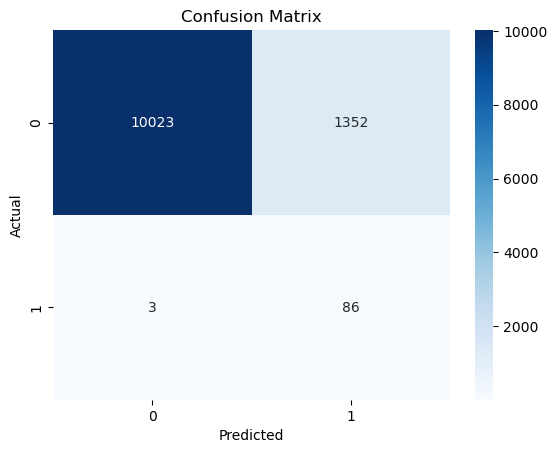

In [23]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(y_val, y_pred):
    
    conf_matrix = confusion_matrix(y_val, y_pred)
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
plot_confusion_matrix(y_test, predictions)

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score
import time

# Hyperparameter grid
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'nu': [0.1, 0.2, 0.5],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]  # Only relevant for poly kernel
}

# Statified K Fold ensures each fold for the grid search contains the same proportion of classes 
stratified_kfold = StratifiedKFold(n_splits = 5, shuffle = True)

# Cross-Validation and Grid Search
grid_search = GridSearchCV(OneClassSVM(), 
                           param_grid, 
                           cv = stratified_kfold,
                           scoring = "roc_auc", 
                           verbose = 2, 
                           n_jobs = -1)

start_time = time.time()
grid_search.fit(X_train_scaled, y_train)
end_time = time.time()

total_training_time = end_time - start_time 